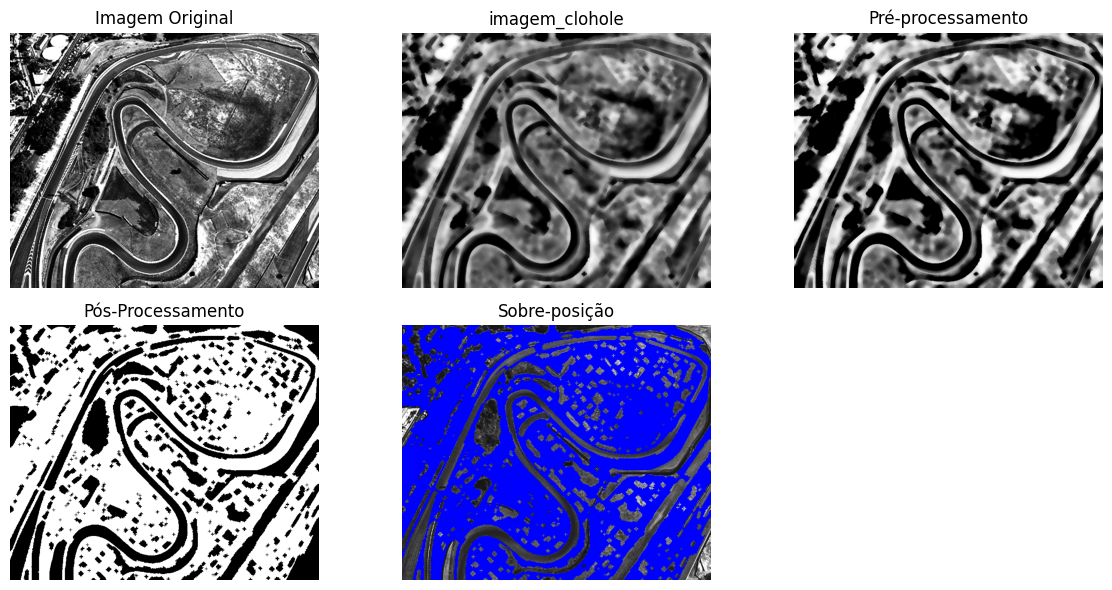

In [2]:

# Maria Júlia Testoni
# O USO DE MORFOLOGIA MATEMÁTICA NA DETECÇÃO DE PISTAS EM AUTÓDROMO
# Autodromo: Sao Jose Carlos

import cv2
import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread('autodromo.png', cv2.IMREAD_GRAYSCALE)

kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (7, 7)) 
kernel_disk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7    ))

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(15, 15))
img_equalizada = clahe.apply(image)
blur = cv2.bilateralFilter(img_equalizada, 15, 130, 130)

blur_closed = cv2.morphologyEx(blur, cv2.MORPH_CLOSE, kernel_disk)

# ======= pré processamento  ===========
# operador basincom limiar 50 e clohole
img_bas = cv2.subtract(blur_closed, 50)
imagem_clohole = cv2.morphologyEx(img_bas, cv2.MORPH_CLOSE, kernel_cross)

# 2 - closeth - sedisk de tamanho 5 - 
fechamento = cv2.morphologyEx(imagem_clohole, cv2.MORPH_CLOSE, kernel_disk)
imagem_closeth = cv2.subtract(fechamento, imagem_clohole)
    
# 3 - operador symdif - partir dos operadores closeth e clohole
imagem_symdif = cv2.absdiff(imagem_closeth, imagem_clohole)

# 4 - operador - histeq
imagem_histeq = cv2.equalizeHist(imagem_symdif)

# 5 - operador hdome com limiar 50,
imagem_hdome = cv2.subtract(imagem_histeq, 50)

# 6 - operador Hmin
imagem_hmin = cv2.add(imagem_hdome, 50)

# 7 - operador Subm
imagem_subm = cv2.subtract(imagem_hmin, imagem_closeth)
imagem_subm = cv2.morphologyEx(imagem_subm, cv2.MORPH_CLOSE, kernel_disk)
imagem_subm = cv2.convertScaleAbs(imagem_subm)

# ===  detecção ====
imagem_binaria = cv2.adaptiveThreshold(imagem_subm.astype(np.uint8), 255, 
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY, 11, 2)

# ======== pós processamento
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(imagem_binaria, connectivity=8)
output = np.zeros_like(imagem_binaria)

for i in range(1, num_labels):  
    if stats[i, cv2.CC_STAT_AREA] >= 8000:  
        output[labels == i] = 255
        
kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (7 ,7))
imagem_dilatada = cv2.dilate(output, kernel_cross, iterations=1)

num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(imagem_dilatada, connectivity=8)
imagem_area_40 = np.zeros_like(imagem_binaria)
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= 40:
        imagem_area_40[labels == i] = 255
        
imagem_erodida = cv2.erode(imagem_area_40, kernel_cross, iterations=1)

num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(imagem_erodida, connectivity=8)
imagem_final = np.zeros_like(imagem_binaria)
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= 700:
        imagem_final[labels == i] = 255

# ====== Sobreposição
imagem_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
imagem_rgb[imagem_final == 255] = [0, 0, 255]  

plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.title('Imagem Original')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('imagem_clohole')
plt.imshow(imagem_clohole, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Pré-processamento')
plt.imshow(imagem_subm, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('Pós-Processamento')
plt.imshow(imagem_final, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Sobre-posição')
plt.imshow(imagem_rgb, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
